This tutorial measures the runtime of Global PDP plots, which are influenced by several factors:

- $t_f$: How heavy the ML model is, i.e., how fast a single evaluation of the model is.
- $N$: The number of instances.
- $D$: The number of features.
- $T$: Number of points used for centering the PDP plot, if needed.
- $T$: The number of points we ask to evaluate on.

We refer to both the points used for centering and the points to evaluate as $T$, because in practice, centering a PDP plot requires evaluating $T$ points.

In this tutorial, we'll focus on $t$, $N$, and $D$ to measure how each influences the runtime of Global PDP.

In Effector, we have two PDP implementations:
- A vectorized version (faster but with higher memory demands)
- A non-vectorized version (slower but uses less memory)

The vectorized version internally creates a matrix of size $(T \times N, D)$, which can challenge memory capacity. We aim to show that, when memory allows, the vectorized option is the better choice.

In [1]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [2]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [3]:
def measure_time(method_name, repetitions):
    pdp_times = []
    for _ in range(repetitions):
        X = np.random.uniform(-1, 1, (N, D))
        xx = np.linspace(-1, 1, T)

        axis_limits = np.zeros((2,D))
        axis_limits[0, :] = -1
        axis_limits[1, :] = 1
        
        start_time = time.time()

        if method_name == "pdp_vectorized":
            pdp = effector.RegionalPDP(data=X, model=model, axis_limits=axis_limits)
            pdp.fit(0, centering=True, points_for_centering=T, use_vectorized=True)
            pdp.eval(feature=0, node_idx=0, xs=xx, centering=True, heterogeneity=True)
        elif method_name == "ale":
            ale = effector.RegionalALE(data=X, model=model, axis_limits=axis_limits)
            ale.fit(0)
            ale.eval(feature=0, node_idx=0, xs=xx, centering=True, heterogeneity=True)
        elif method_name == "rhale":
            data_effect = model_jac(X)
            rhale = effector.RegionalRHALE(data=X, model=model, model_jac=model_jac, instance_effects=data_effect, axis_limits=axis_limits)
            binning_method = effector.binning_methods.Fixed(nof_bins=20)
            rhale.fit(0, binning_method=binning_method)
            rhale.eval(feature=0, node_idx=0, xs=xx, centering=True, heterogeneity=True)
            
    
        pdp_times.append(time.time() - start_time)
    return np.mean(pdp_times)/repetitions

## PDP time vs t (time for a single evaluation of f)

In [4]:
t = 0.001
N = 10_000
D = 10
T = 100

In [5]:
vec = [10**-5, 10**-4, 10**-3, 10**-2] # , 10**-1]# , 1]
time_dict = {"ale": [], "rhale": [], "pdp_vectorized":[]}
for t in vec:
    print("t:", t)
    model = return_predict(t)
    model_jac = return_jacobian(t)
    print("ALE")
    time_dict["ale"].append(measure_time("ale", 3))
    print("RHALE")
    time_dict["rhale"].append(measure_time("rhale", 3))
    print("PDP")
    time_dict["pdp_vectorized"].append(measure_time("pdp_vectorized", 3))

t: 1e-05
ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.82it/s]


t: 0.0001
ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.80it/s]


t: 0.001
ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


t: 0.01
ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.48s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


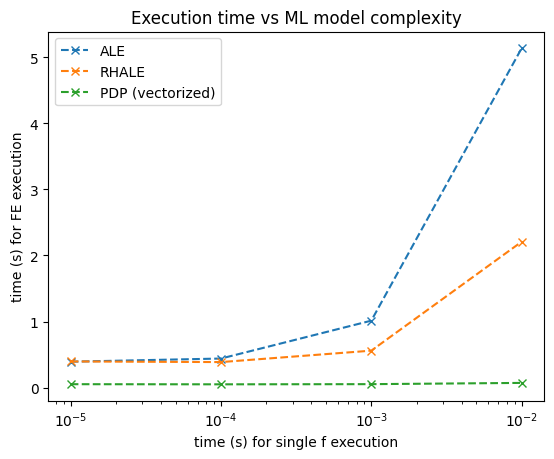

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(vec, time_dict["ale"], "x--", label="ALE")
plt.plot(vec, time_dict["rhale"], "x--", label="RHALE")
plt.plot(vec, time_dict["pdp_vectorized"], "x--", label="PDP (vectorized)")
plt.title("Execution time vs ML model complexity")
plt.xlabel("time (s) for single f execution")
plt.ylabel("time (s) for FE execution")
plt.xscale("log")
plt.legend()
plt.show()

## PDP time vs N (nof instances)

In [7]:
t = 0.001
N = 10_000
D = 10
T = 100

In [8]:
vec = [1_000, 10_000, 50_000, 100_000] # 1_000_000]
time_dict = {"ale": [], "rhale": [], "pdp_vectorized":[]}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    print("ALE")
    time_dict["ale"].append(measure_time("ale", 3))
    print("RHALE")
    time_dict["rhale"].append(measure_time("rhale", 3))
    print("PDP")
    time_dict["pdp_vectorized"].append(measure_time("pdp_vectorized", 3))

ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.02it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.97it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.83s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.65s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.82it/s]


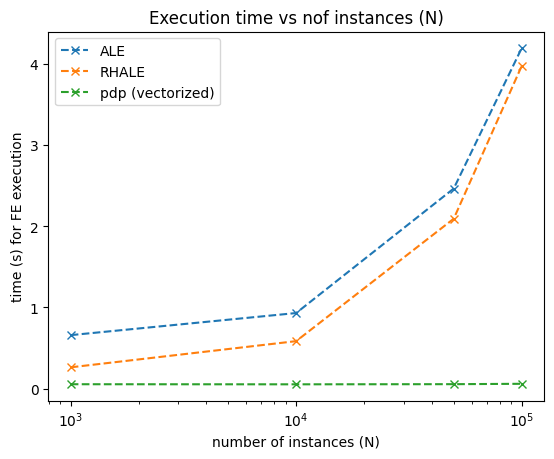

In [9]:
plt.figure()
plt.plot(vec, time_dict["ale"], "x--", label="ALE")
plt.plot(vec, time_dict["rhale"], "x--", label="RHALE")
plt.plot(vec, time_dict["pdp_vectorized"], "x--", label="pdp (vectorized)")
plt.title("Execution time vs nof instances (N)")
plt.xlabel("number of instances (N)")
plt.ylabel("time (s) for FE execution")
plt.xscale("log")
plt.legend()
plt.show()

## PDP time vs D (nof features)

In [10]:
t = 0.001
N = 10_000
T = 100

In [11]:
vec = [5, 10, 20, 30] # 50, 100, 200, 300]
time_dict = {"ale": [], "rhale": [], "pdp_vectorized":[]}
for D in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    print("ALE")
    time_dict["ale"].append(measure_time("ale", 3))
    print("RHALE")
    time_dict["rhale"].append(measure_time("rhale", 3))
    print("PDP")
    time_dict["pdp_vectorized"].append(measure_time("pdp_vectorized", 3))

ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


ALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.88s/it]


RHALE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]


PDP


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


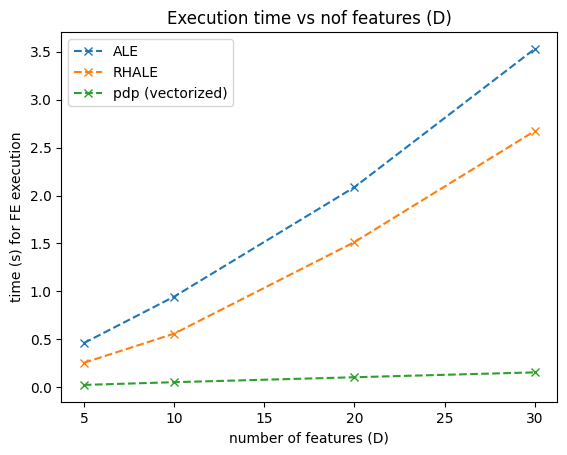

In [12]:
plt.figure()
plt.plot(vec, time_dict["ale"], "x--", label="ALE")
plt.plot(vec, time_dict["rhale"], "x--", label="RHALE")
plt.plot(vec, time_dict["pdp_vectorized"], "x--", label="pdp (vectorized)")
plt.title("Execution time vs nof features (D)")
plt.xlabel("number of features (D)")
plt.ylabel("time (s) for FE execution")
# plt.xscale("log")
plt.legend()
plt.show()

## Conclusion

In practice, the vectorized version outperforms the non-vectorized version in all cases:

- The runtime of the black-box model is the key factor. As the model size increases, the non-vectorized implementation shows a linear increase in runtime, while the vectorized implementation remains unaffected.
- The number of instances does not significantly impact the runtime for either version, as long as \( y \) can be obtained in a single pass of \( f(x) \).
- Both versions scale linearly with the number of features, but the vectorized version is consistently faster by a constant margin.